## Test 12/07/2024 - Update Retrieval Evaluation process

Goal:
The previous tests were conducted using a dataset comprising the 100 largest available documents from the raw database. As a result, this high-quality content may not accurately reflect the distribution of data in the entire vector database. While we can observe differences between the configurations, it is challenging to determine which combination is the best choice for our use case among the top configurations.

Several experiments will be done : 
- add random documents to the base corpus (uniformly distributed)
- add other big documents to the base corpus (keeping the same extraction procedure of the top N largest content documents)

what to observe : 
- evolution of the retrieval metrics facing this added noise. 

Assumption : run python src/db_building/insee_data_processing.py in the terminal

In [1]:
import sys

sys.path.append("../src")

import os 
import pandas as pd
import numpy as np
from typing import List 
from collections import Counter
import matplotlib.pyplot as plt 
from typing import List, Dict 
import math 
from tqdm import tqdm 
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

from db_building import extract_paragraphs
from doc_building import compute_autokonenizer_chunk_size, build_documents_from_dataframe
from evaluation import RetrievalConfiguration, hist_results, plot_results
from config import MARKDOWN_SEPARATORS, DB_DIR_LOCAL, EMB_DEVICE


In [3]:
data = pd.read_csv("../data_complete.csv", low_memory=False) # we assume the textual information have already been extracted. 

In [4]:
results = extract_paragraphs(data) 

7778it [00:03, 1687.00it/s]

43226it [01:03, 680.28it/s] 


In [5]:
ds = pd.DataFrame.from_dict(results)
ds.to_csv("insee_documents.csv", index=False)

In [16]:
ds = pd.read_csv("../data/insee_documents.csv")

In [17]:
ds.head(3)

,id_origin,paragraphs,url_source,title,categories,dateDiffusion,themes,collections,libelleAffichageGeo,intertitres,authors,subtitle
0,1280888,"Entre 2008 et 2010, dans un contexte de crise,...",https://www.insee.fr/fr/statistiques/1280888,Innover pour résister à la crise ou se dévelop...,Publications grand public,2012-10-23T22:00:00Z,"Mondialisation, compétitivité et innovation",Insee Première,France,"Entre 2008 et 2010, la moitié des sociétés de ...",NaN,NaN
1,1280890,"En 2011, le déficit public s’établit à 103,1mi...",https://www.insee.fr/fr/statistiques/1280890,Les comptes des administrations publiques en 2011,Publications grand public,2012-05-15T05:30:00Z,Finances publiques,Insee Première,France,"En 2011, le déficit public atteint 5,2 % du PI...",NaN,NaN
2,1280892,L’année agricole 2012 est marquée par l’abonda...,https://www.insee.fr/fr/statistiques/1280892,Les comptes prévisionnels de l’agriculture pou...,Publications grand public,2012-12-12T16:00:00Z,Agriculture,Insee Première,France,Le prix des céréales augmente fortement Le pri...,NaN,Les récoltes de céréales augmentent et leurs p...


Run in the terminal : mc cp s3/projet-llm-insee-open-data/data/eval_data/eval_retrieval/q_and_a_scored_filtered_Phi-3-mini-128k-instruct.csv data/

In [2]:
#question and answer
path_qa = "../data/q_and_a_scored_filtered_Phi-3-mini-128k-instruct.csv"
test = pd.read_csv(path_qa)

df_dict = {}
df_dict["the_df_dataset"] = test

In [21]:
langchain_docs = [LangchainDocument(
            page_content= doc["paragraphs"],
             metadata={
                "source": doc["url_source"], 
                "title": doc["title"],
                "insee_id": doc["id_origin"], 
                "categories" : doc["categories"],
                "date_diffusion" : doc["dateDiffusion"], 
                "themes" : doc["themes"],
                "collections" : doc["collections"], 
                "libelleAffichageGeo" : doc["libelleAffichageGeo"], 
                "intertitres" : doc["intertitres"],
                "authors" : doc["authors"],
                "subtitle" : doc["subtitle"]
             }) for _, doc in tqdm(ds.iterrows())]

34567it [00:02, 15146.18it/s]


In [22]:
def get_top_n_documents_with_largest_content(documents : List[LangchainDocument], n=1000):
    # Create a list of tuples (content_size, document)
    document_sizes = [(len(doc.page_content.split()), doc) for doc in documents]

    # Sort the list by content size in descending order
    sorted_documents = sorted(document_sizes, key=lambda x: x[0], reverse=True)

    # Get the top N documents
    top_n_documents = [doc for (_ , doc) in sorted_documents[:n]]

    return top_n_documents

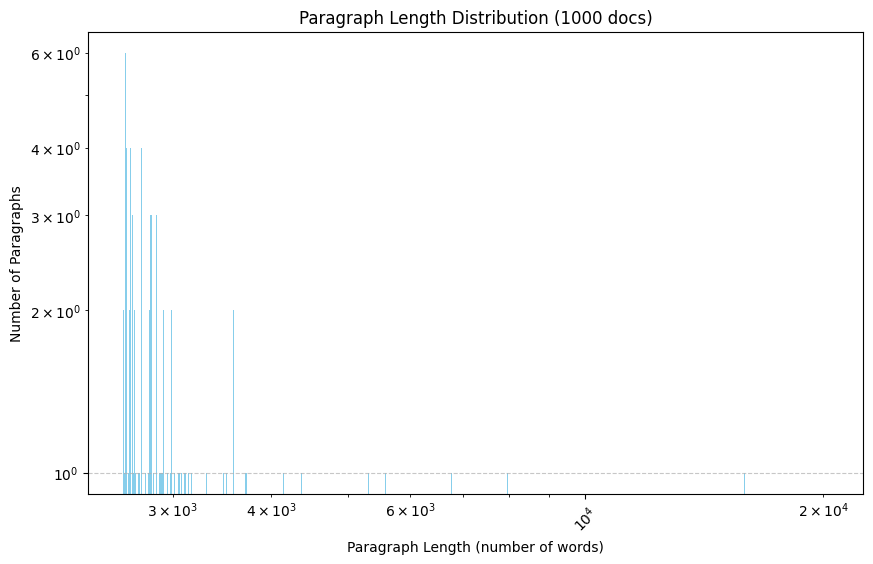

In [20]:
sample_langchain_docs = get_top_n_documents_with_largest_content(langchain_docs, n=1000)

counters_para = Counter()

for doc in sample_langchain_docs:
    counters_para[len(doc.page_content.split())] +=1

lengths_sorted = sorted(counters_para.items())
lengths , counts = zip(*lengths_sorted)
# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(lengths, counts, color='skyblue')
plt.xlabel('Paragraph Length (number of words)')
plt.ylabel('Number of Paragraphs')
plt.title( f'Paragraph Length Distribution ({len(sample_langchain_docs)} docs)')
plt.xticks(rotation=45)
plt.xscale("log")
plt.yscale("log")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
import chromadb
def from_docs_to_vector_database(langchain_docs: List[LangchainDocument], mode: str = "random", top_n = 100, config: RetrievalConfiguration = None): 

    if mode=="random":
        np.random.seed(42) 
        top_documents = get_top_n_documents_with_largest_content(langchain_docs, n=100) 
        indices = np.random.randint(low=100, high=len(langchain_docs), size=top_n-100, dtype=int)
        sample_langchain_docs = top_documents + [langchain_docs[i] for i in indices]
    elif mode=="top":
        sample_langchain_docs = get_top_n_documents_with_largest_content(langchain_docs, n=top_n) 

    autokenizer, chunk_size, chunk_overlap = compute_autokonenizer_chunk_size(config.get("embedding_model_name"))
    
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        autokenizer,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=MARKDOWN_SEPARATORS,
    )
    docs_processed = text_splitter.split_documents(sample_langchain_docs)

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    embedding_model = HuggingFaceEmbeddings(  # load from sentence transformers
        model_name=config.get("embedding_model_name"),
        model_kwargs={"device": EMB_DEVICE, "trust_remote_code": True},
        encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
        show_progress=False,
    )
    # Process documents in batches
    chroma_client = chromadb.PersistentClient
    max_batch_size = chroma_client._producer.max_batch_size

    for i in range(0, len(docs_processed_unique), max_batch_size):
        batch_docs = docs_processed_unique[i:i + max_batch_size]
        db = Chroma.from_documents(
            collection_name=config.get("collection"),
            documents=batch_docs,
            persist_directory=DB_DIR_LOCAL,
            embedding=embedding_model,
        )
    

In [18]:
list_nb_docs = [10000, 15000, 20000, 30000, 35000, 40000]
list_config = [ 
    RetrievalConfiguration(
        name=f'test_docs_{nb_docs}',
        database="chromadb",
        collection=f"Solon-embeddings-large-0.1_docs_{nb_docs}",
        database_path=None,
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type=None,
        reranker_name=None,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50]
        )
        for nb_docs in list_nb_docs
]

In [ ]:
for (config, nb_doc) in zip(list_config, list_nb_docs):
    from_docs_to_vector_database(langchain_docs=langchain_docs, mode="random", top_n=nb_doc, config=config)

In [ ]:
from evaluation import RetrievalEvaluator

results = RetrievalEvaluator.run(
    eval_configurations=list_config,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)

### Experiment : Random Documents Injection (seed 42)

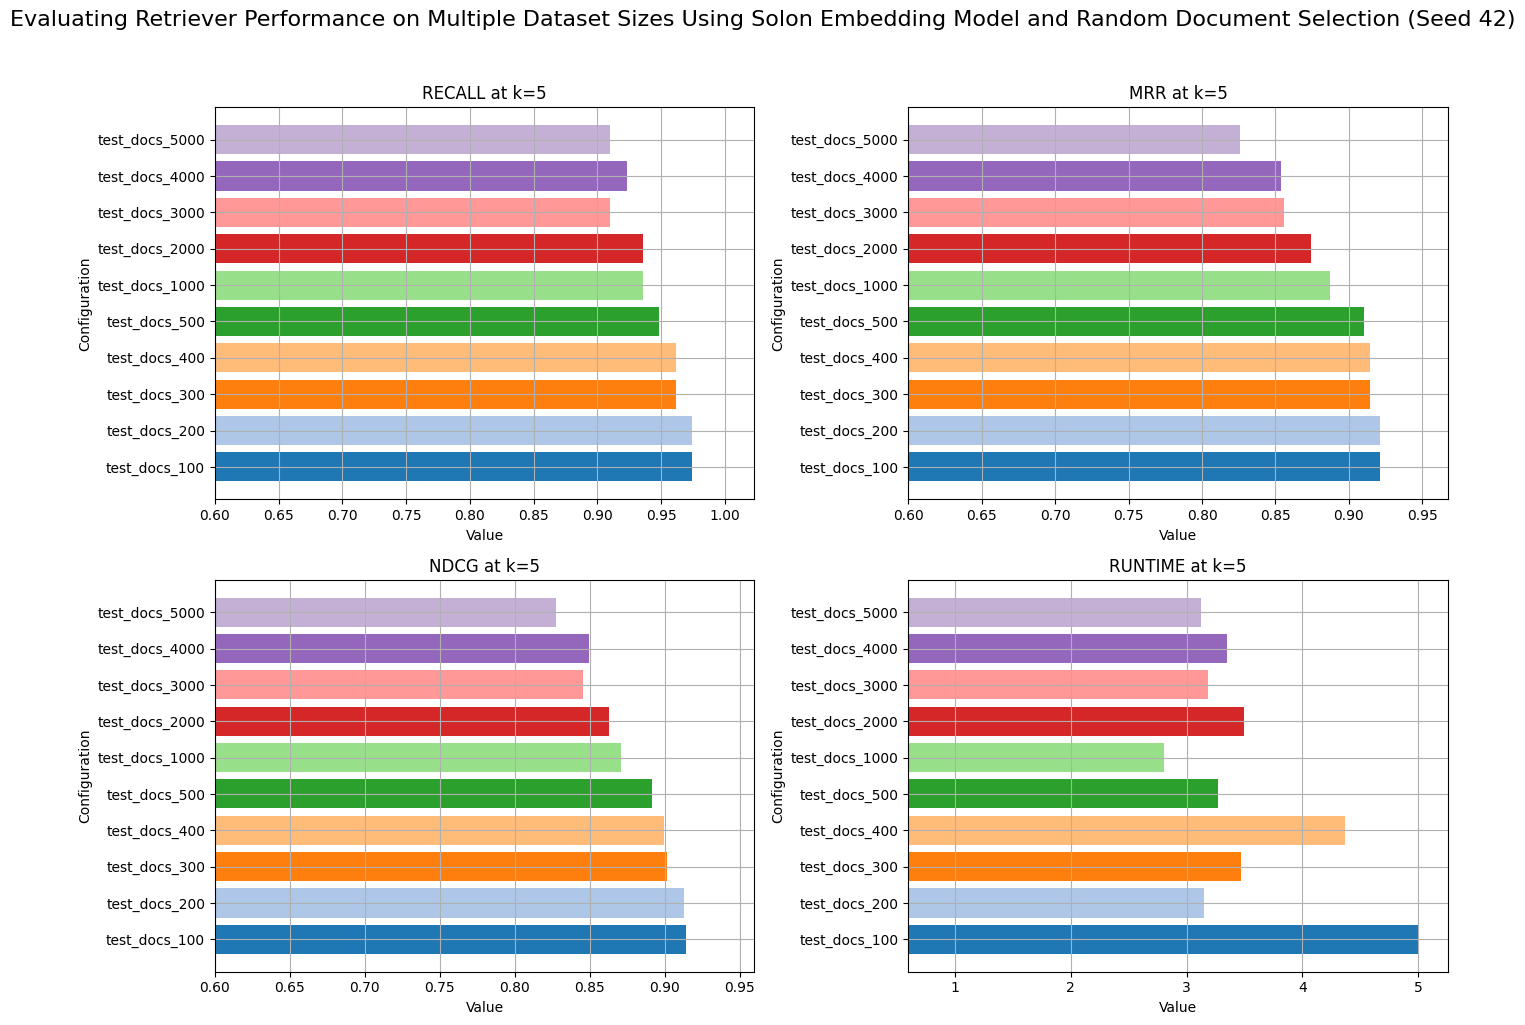

In [ ]:
hist_results(
    list_config, 
    results["the_df_dataset"], 
    ir_metrics=['recall', 'mrr', 'ndcg','runtime'], 
    focus="name", 
    title = "Evaluating Retriever Performance on Multiple Dataset Sizes Using Solon Embedding Model and Random Document Selection (Seed 42)",
    k = 5)

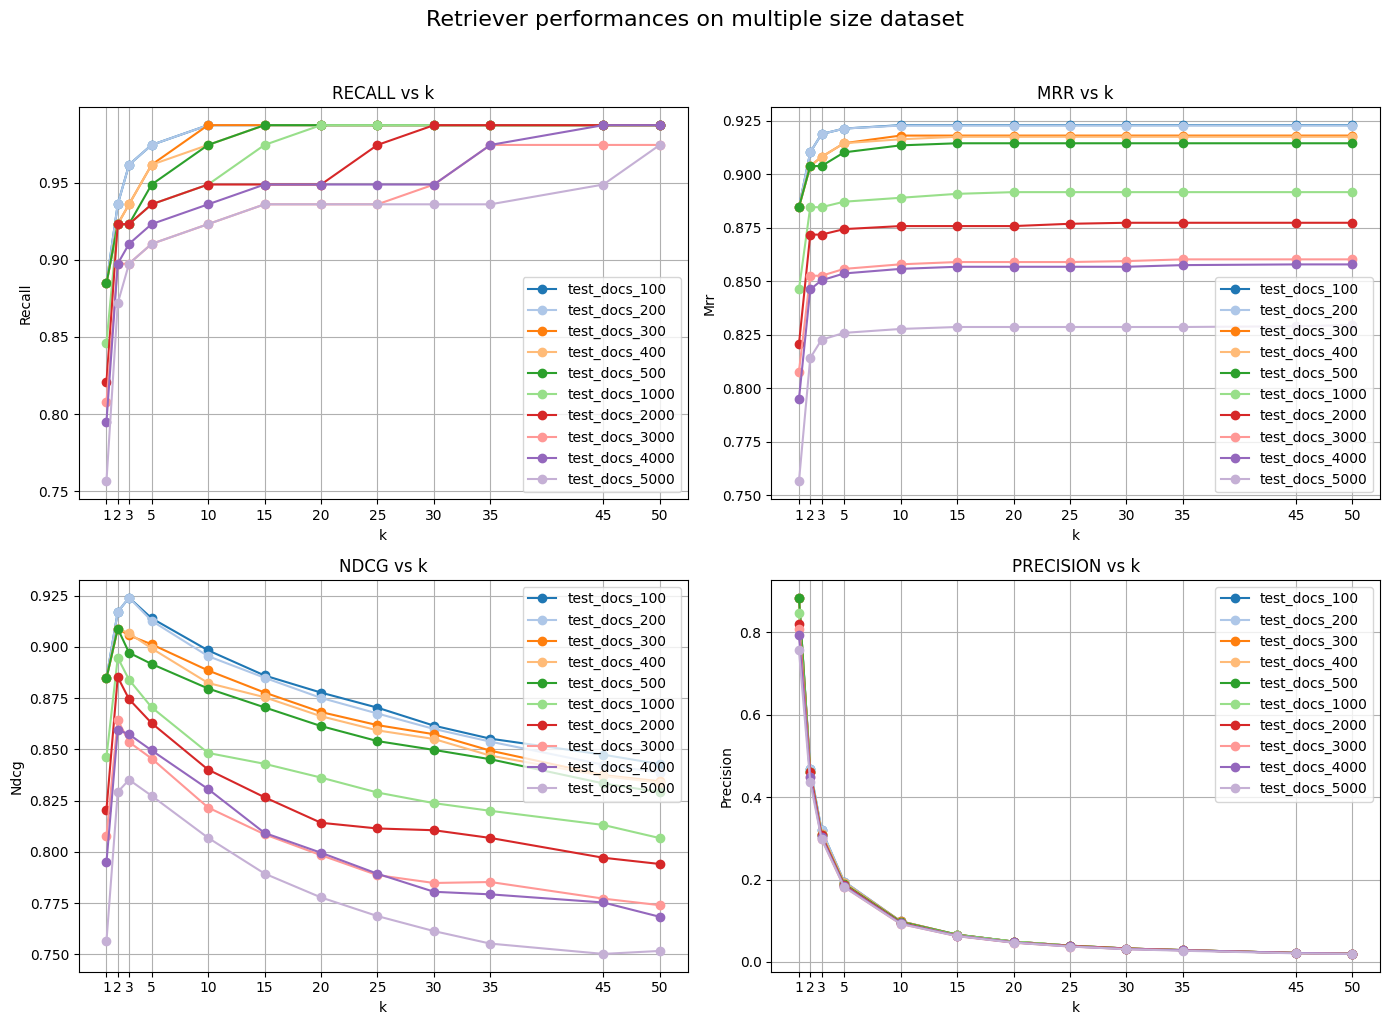

In [ ]:
plot_results(
    list_config, 
    results["the_df_dataset"], 
    ir_metrics=['recall', 'mrr', 'ndcg', 'precision'], 
    focus="name", 
    title = "Retriever performances on multiple size dataset",
    k = 50)

### Experiment : On Full Dataset

In [23]:
cross_encoders = ["BAAI/bge-reranker-v2-m3", "antoinelouis/crossencoder-camembert-large-mmarcoFR", "BAAI/bge-reranker-base"]
colberts = ["bclavie/FraColBERTv2", "antoinelouis/colbertv2-camembert-L4-mmarcoFR"]

colbert_vs_cross_encoder_eval_config = [
    RetrievalConfiguration(
        name=f'cross_encoder_{i}',
        database="chromadb",
        collection="insee_data",
        database_path=None,
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type="Cross-encoder",
        reranker_name=cross_encoder,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        rerank_k= 50
    ) for i, cross_encoder in enumerate(cross_encoders)] + [
    RetrievalConfiguration(
        name=f'colbert_{i}',
        database="chromadb",
        collection="insee_data",
        database_path=None,
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type="ColBERT",
        reranker_name=colbert,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        rerank_k= 50
    ) for i, colbert in enumerate(colberts)] + [
    RetrievalConfiguration(
        name=f'baseline',
        database="chromadb",
        collection="insee_data",
        database_path=None,
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type=None,
        reranker_name=None,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        rerank_k= 50
        )
    ]
        

In [ ]:
# Run the evaluator
results_colbert_vs_cross_encoder = RetrievalEvaluator.run(
    eval_configurations = colbert_vs_cross_encoder_eval_config,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)

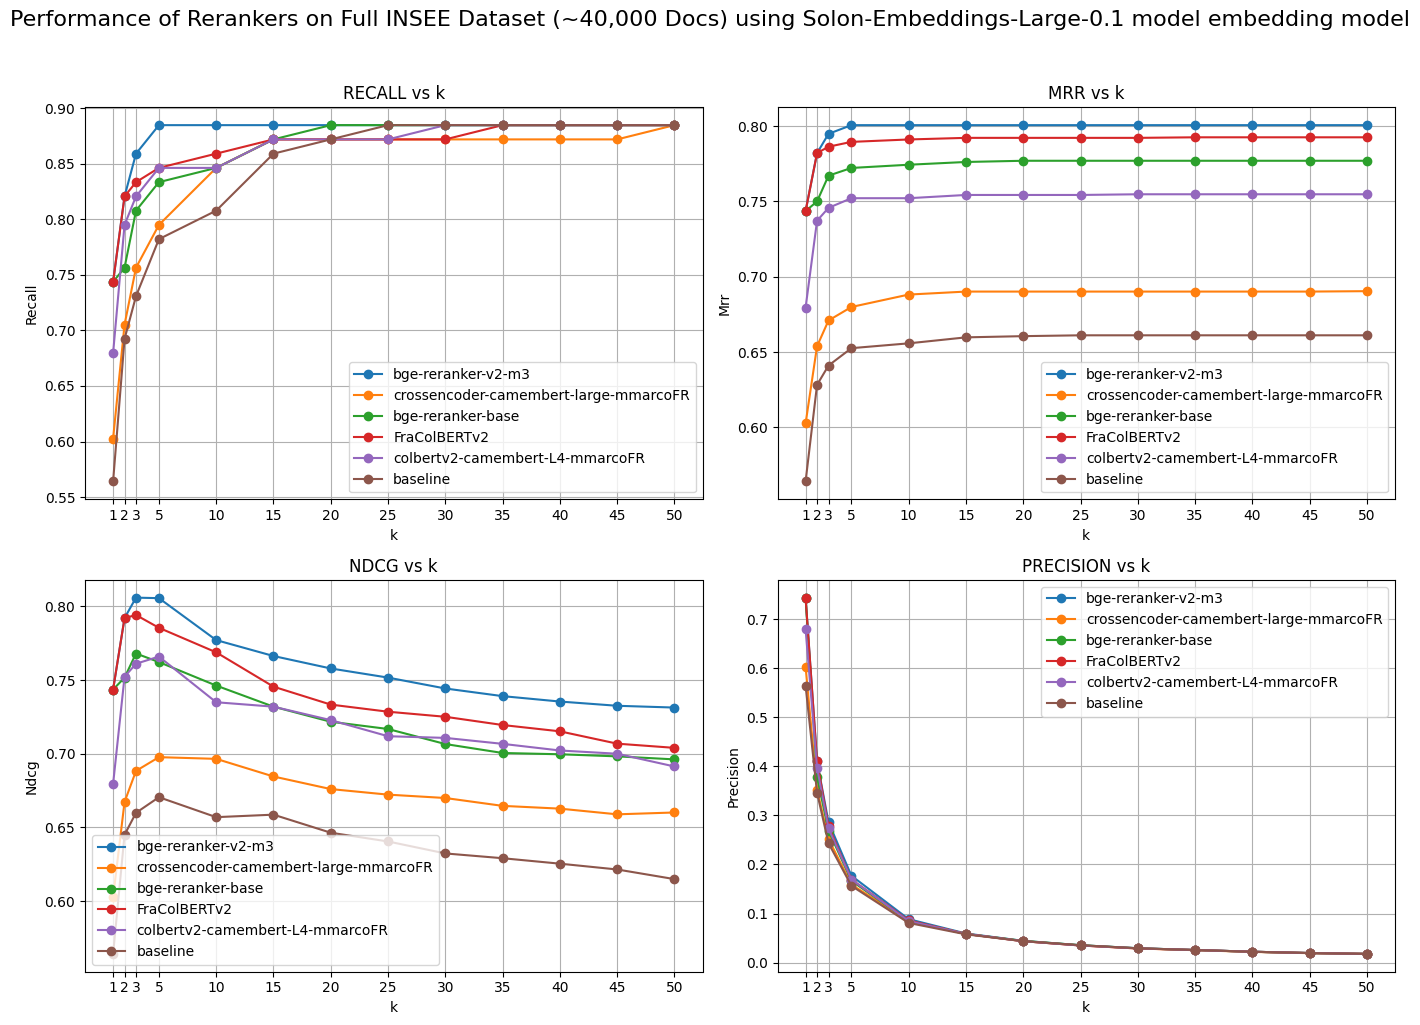

In [28]:
# Run the evaluator
plot_results(
    colbert_vs_cross_encoder_eval_config, 
    results_colbert_vs_cross_encoder["the_df_dataset"], 
    ir_metrics=['recall', 'mrr', 'ndcg', 'precision'], 
    focus= "reranker_name", 
    title = "Performance of Rerankers on Full INSEE Dataset (~40,000 Docs) using Solon-Embeddings-Large-0.1 model embedding model",
    k = 50,
    cmap_name = "tab10"
    )

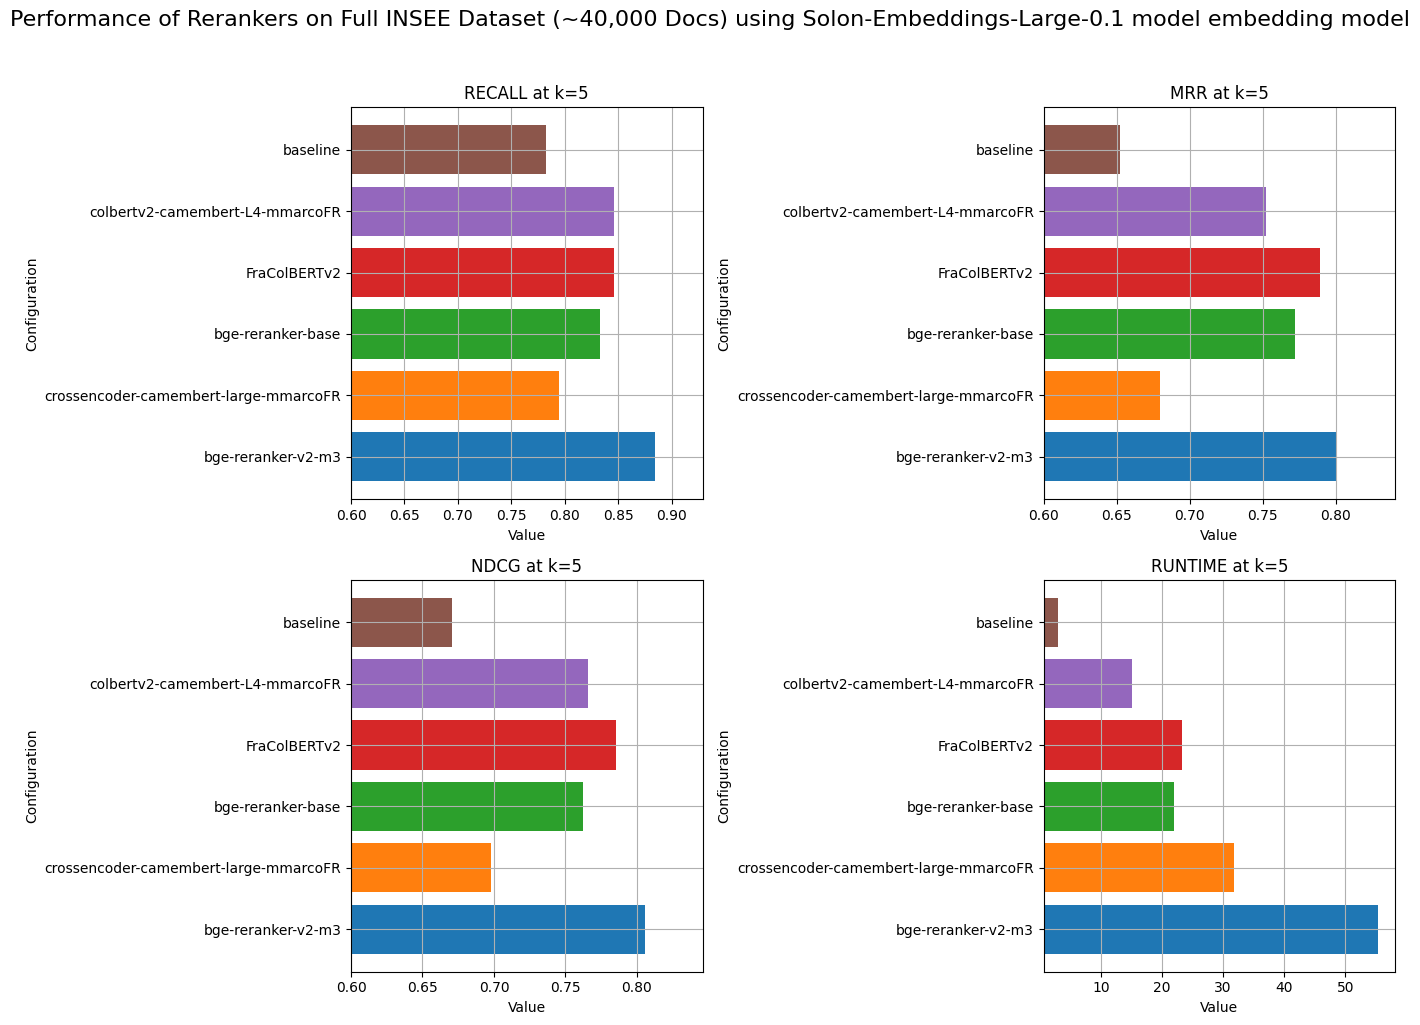

In [38]:
# Run the evaluator
hist_results(
    colbert_vs_cross_encoder_eval_config, 
    results_colbert_vs_cross_encoder["the_df_dataset"], 
    ir_metrics=['recall', 'mrr', 'ndcg',"runtime"], 
    focus = "reranker_name", 
    title = "Performance of Rerankers on Full INSEE Dataset (~40,000 Docs) using Solon-Embeddings-Large-0.1 model embedding model",
    k = 5,
    cmap_name = "tab10",
    x_min=0.6
    )

In [52]:
import copy

def compute_performance(results):
    config_names = [config_name for config_name in results.keys()]
    
    if "baseline" in config_names:
        results_percentages = copy.deepcopy(results)  # Use deepcopy to avoid modifying the original
        result_baseline = results["baseline"]
        
        for config_name, config_res in results.items():
            if config_name == "baseline":
                continue  # Skip baseline itself
            for metric in config_res.keys():
                if isinstance(config_res[metric], dict):
                    for i in config_res[metric]:
                        base_res = result_baseline[metric][i]
                        res = config_res[metric][i]
                        res_over_baseline = ((res - base_res) / base_res) * 100
                        results_percentages[config_name][metric][i] = res_over_baseline
                elif isinstance(config_res[metric], float):
                    base_res = result_baseline[metric]
                    res = config_res[metric]
                    res_over_baseline = ((res - base_res) / base_res) * 100
                    results_percentages[config_name][metric] = res_over_baseline
        
        return results_percentages
    else: 
        return None


In [53]:
results_percentages_over_baseline = compute_performance(results=results_colbert_vs_cross_encoder["the_df_dataset"])

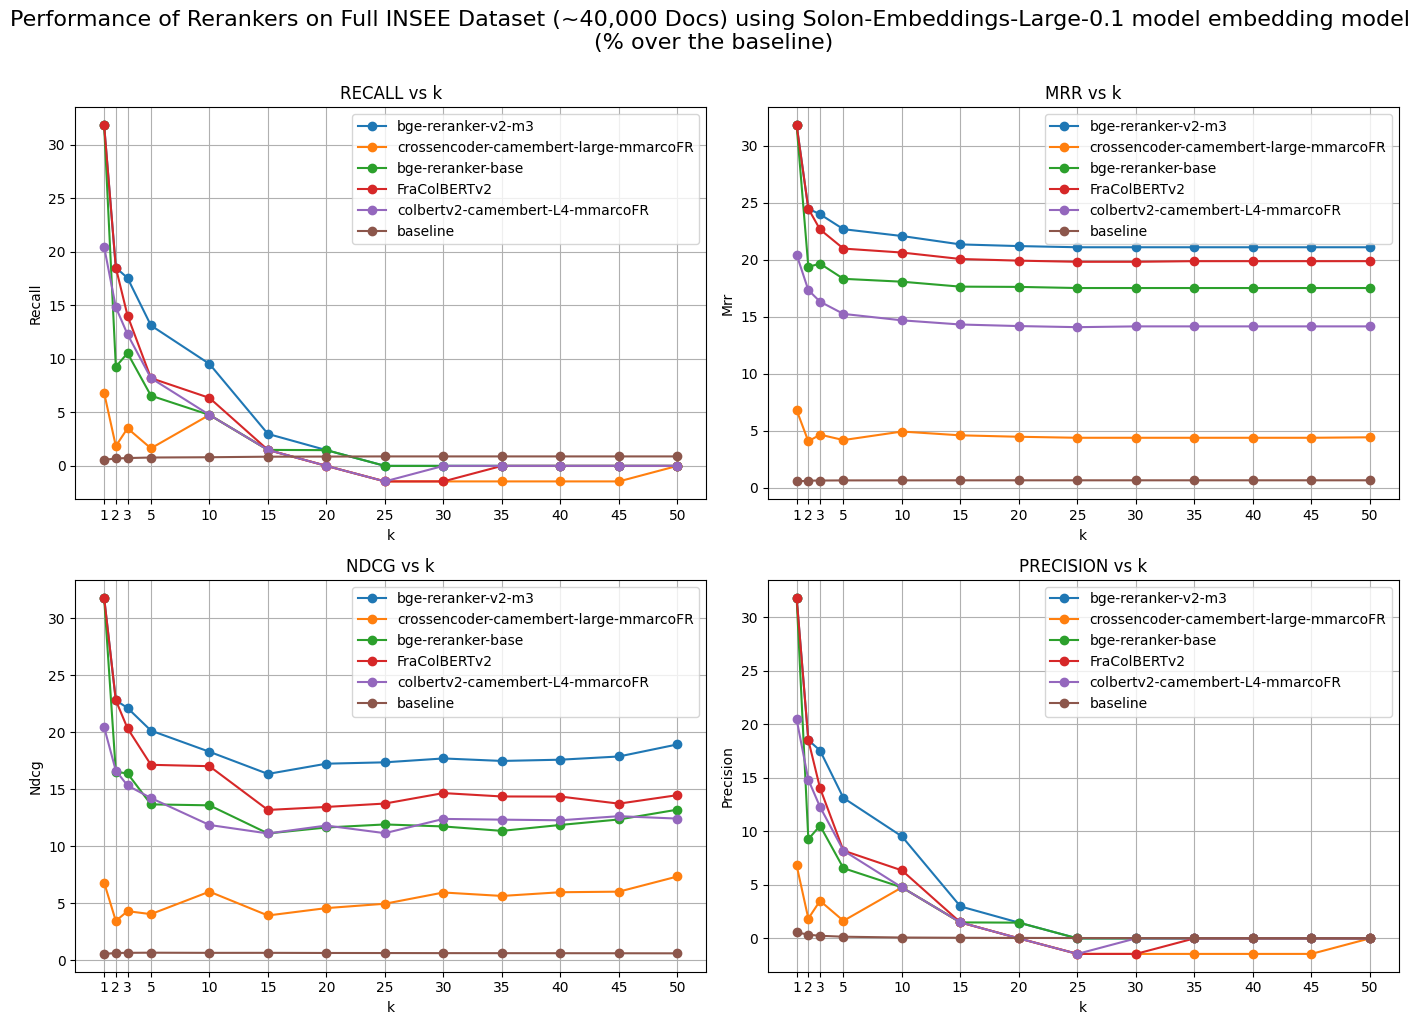

In [58]:
plot_results(
    colbert_vs_cross_encoder_eval_config, 
    results_percentages_over_baseline, 
    ir_metrics=['recall', 'mrr', 'ndcg', 'precision'], 
    focus= "reranker_name", 
    title = "Performance of Rerankers on Full INSEE Dataset (~40,000 Docs) using Solon-Embeddings-Large-0.1 model embedding model \n(% over the baseline)",
    k = 50,
    cmap_name = "tab10"
    )

### Experiment : Longest Documents Injection

In [11]:
list_nb_docs = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [12]:
list_config = [ 
    RetrievalConfiguration(
        name=f'test_docs_{nb_docs}',
        database="chromadb",
        collection=f"Solon-embeddings-large-0.1_docs_{nb_docs}",
        database_path=None,
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type=None,
        reranker_name=None,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50]
        )
        for nb_docs in list_nb_docs
]

for (config, nb_doc) in zip(list_config, list_nb_docs):
    from_docs_to_vector_database(langchain_docs=langchain_docs, mode="top", top_n=nb_doc, config=config)

Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors
2024-07-15 12:54:17,499 - INFO - Load pretrained SentenceTransformer: OrdalieTech/Solon-embeddings-large-0.1
2024-07-15 12:54:21,312 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors
2024-07-15 12:55:19,850 - INFO - Load pretrained SentenceTransformer: OrdalieTech/Solon-embeddings-large-0.1
Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors
2024-07-15 12:56:49,431 - INFO - Load pretrained SentenceTransformer: OrdalieTech/Solon-em

In [ ]:
from evaluation import RetrievalEvaluator

results = RetrievalEvaluator.run(
    eval_configurations=list_config,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)

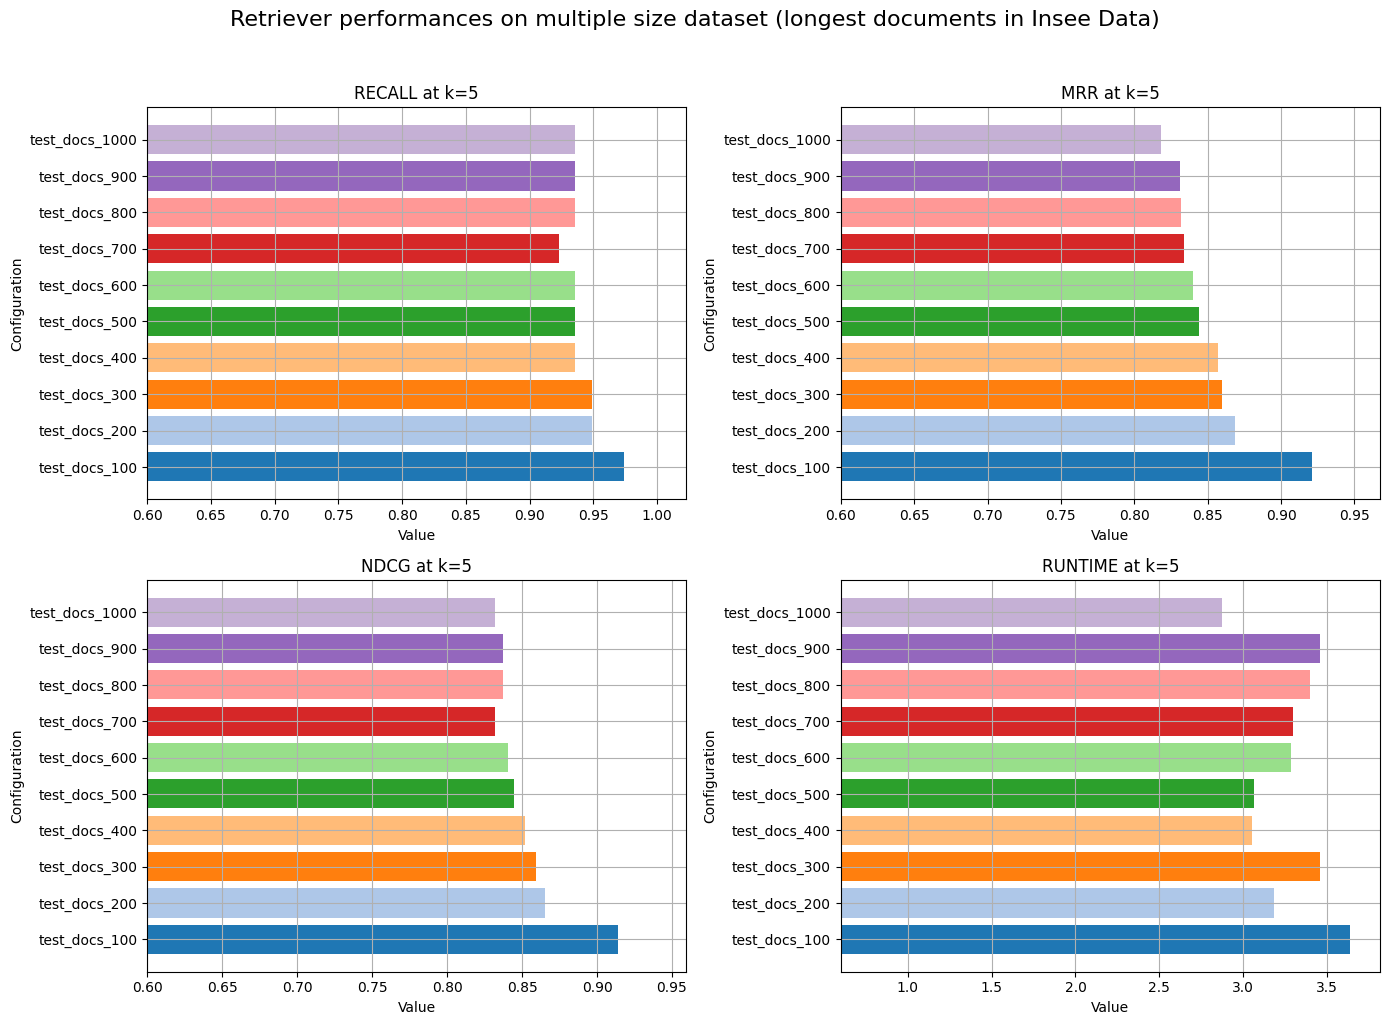

In [15]:
hist_results(
    list_config, 
    results["the_df_dataset"], 
    ir_metrics=['recall', 'mrr', 'ndcg','runtime'], 
    focus="name", 
    title = "Retriever performances on multiple size dataset (longest documents in Insee Data)",
    k = 5)

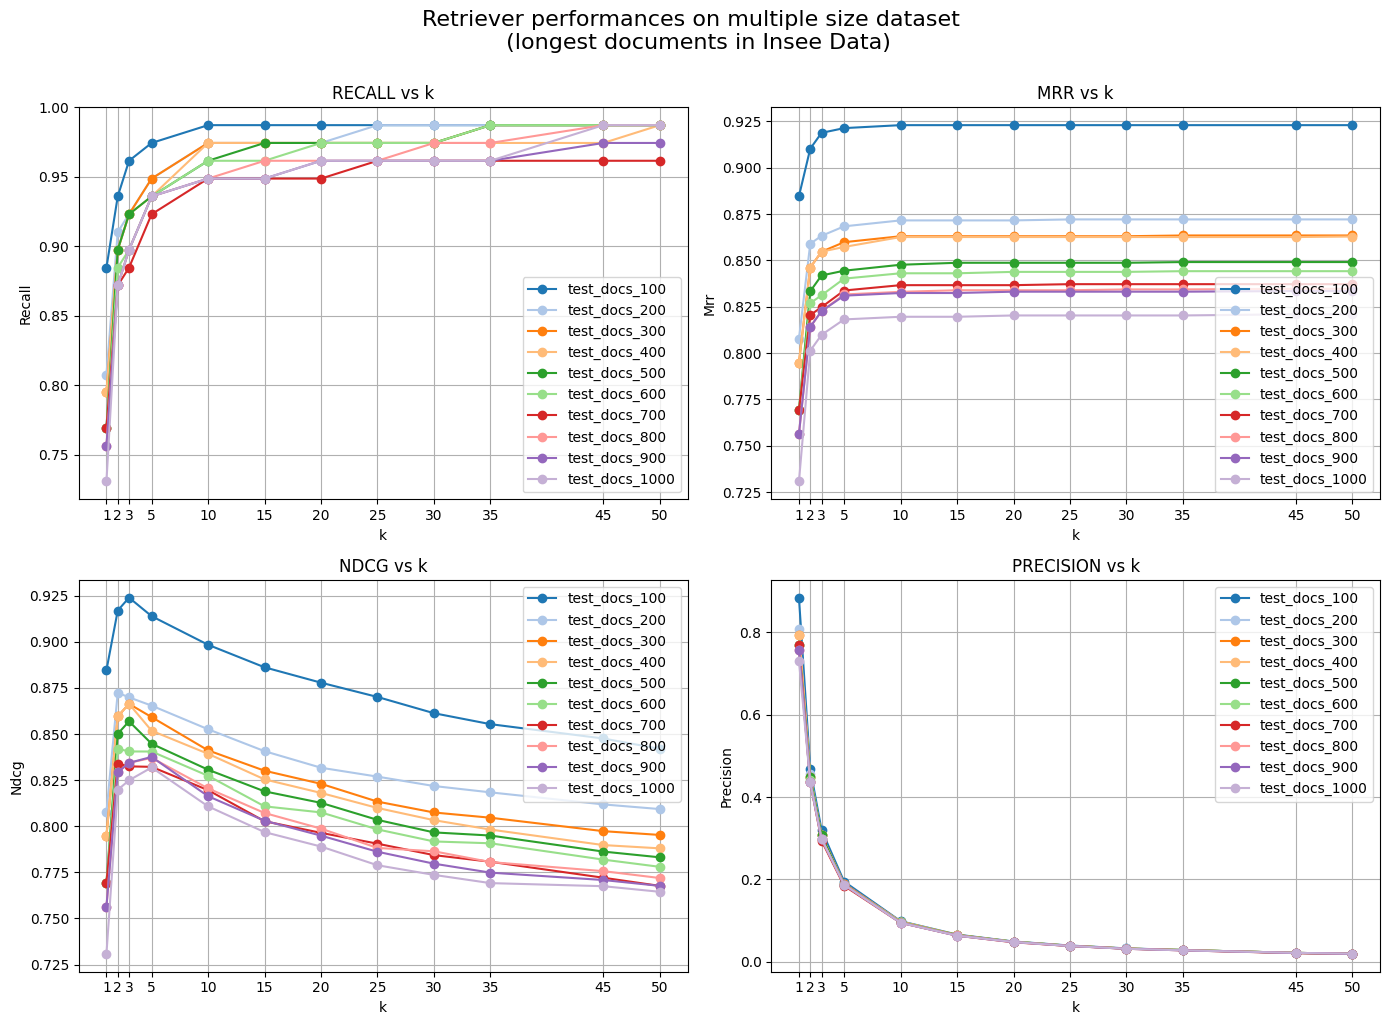

In [21]:
plot_results(
    list_config, 
    results["the_df_dataset"], 
    ir_metrics=['recall', 'mrr', 'ndcg','precision'], 
    focus="name", 
    title = "Retriever performances on multiple size dataset \n (longest documents in Insee Data)",
    k = 50)

## Experiment 04/09/24 : Choosing embedding hyperparameters (Token length and Overlap Size)

In [23]:
# top 1000 longest documents
top_documents = get_top_n_documents_with_largest_content(langchain_docs, n=200) 
sample_langchain_docs = top_documents

In [24]:
def save_langchain_docs(langchain_docs):
    df = {
           "content": [],
            "source": []
    }

    for doc in tqdm(langchain_docs): 
        df["content"].append(doc.page_content)
        df["source"].append(doc.metadata["source"])
    
    df = pd.DataFrame.from_dict(df)
    df.to_csv(f"insee_{len(df)}_samples_corpus.csv")

In [25]:
save_langchain_docs(sample_langchain_docs)

100%|██████████| 200/200 [00:00<00:00, 149130.81it/s]


In [4]:
# Defining the tested configurations
chunk_size_list = list(range(400, 525, 25))
overlap_size_list = list(range(0, 110, 25))
list_configs = [] 
for chunk_size in chunk_size_list:
    for overlap_size in overlap_size_list:
        config = RetrievalConfiguration(
                name=f'test_chunk={chunk_size}_overlap={overlap_size}',
                database="chromadb",
                collection=f"Solon-embeddings-large-0.1_{chunk_size}_{overlap_size}",
                database_path="../data/insee_200_samples_corpus.csv",
                embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
                reranker_type=None,
                chunk_size=chunk_size,
                overlap_size=overlap_size,
                reranker_name=None,
                k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                rerank_k=50
        )
        list_configs.append(config)

In [5]:
from evaluation import RetrievalEvaluator

results = RetrievalEvaluator.run(
    eval_configurations=list_configs,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)

2024-09-04 20:09:19,031 - INFO - Start of evaluation run for dataset: the_df_dataset and configuration: test_chunk=400_overlap=0
2024-09-04 20:09:19,035 - INFO - Created persist directory: ../data/chroma_db
2024-09-04 20:09:19,049 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-09-04 20:09:21,581 - INFO - collection name : Solon-embeddings-large-0.1_400_0
2024-09-04 20:09:21,582 - INFO - The available collections : []
2024-09-04 20:09:21,582 - INFO - The database will be created
2024-09-04 20:09:21,701 - INFO - The database will be stored in ../data/chroma_db
2024-09-04 20:09:21,702 - INFO - Building the list of Document objects
2024-09-04 20:09:22,590 - INFO - The associated collection name : Solon-embeddings-large-0.1_400_0
--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/logging/__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^

In [ ]:
plot_results(
    list_configs, 
    results["the_df_dataset"], 
    ir_metrics=['ndcg', 'recall','mrr'], 
    focus="name", 
    title="Chunk size and Overlap size",
    k = 50,
    cmap_name = "tab20"
    )

In [15]:
def heatmap_of_metric_at_k(eval_configs: list[RetrievalConfiguration], 
                           results: dict[str, dict[str, dict[int, float]]], 
                           metric: str, 
                           k: int = 15, 
                           title: str = "", 
                           cmap_name: str = 'viridis'):
    """
    Displays a heatmap of a given IR metric at a certain k across different retrieval configurations,
    with chunk_size and overlap_size as the axes.
    
    Parameters:
    - eval_configs: list of RetrievalConfiguration objects.
    - results: dictionary of results where the keys are configuration names and values are dictionaries 
               of metrics.
    - metric: The IR metric to display (e.g., 'recall', 'precision', 'mrr', 'ndcg').
    - k: The value of k for which the metric is displayed (default is 15).
    - title: The title of the heatmap (default is an empty string).
    - cmap_name: The colormap to use for the heatmap (default is 'viridis').
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create a dictionary to hold heatmap data
    heatmap_dict = {}

    for config in eval_configs:
        config_results = results.get(config.name, {})
        metric_values = config_results.get(metric, {})
        value = metric_values.get(k) if isinstance(metric_values, dict) else metric_values
        
        if value is not None:
            chunk_size = config.chunk_size
            overlap_size = config.overlap_size
            
            if chunk_size not in heatmap_dict:
                heatmap_dict[chunk_size] = {}
            heatmap_dict[chunk_size][overlap_size] = value
    
    # Sort the chunk_size and overlap_size for consistent plotting
    chunk_sizes = sorted(heatmap_dict.keys())
    overlap_sizes = sorted({overlap for overlaps in heatmap_dict.values() for overlap in overlaps})

    # Prepare the heatmap data array
    heatmap_data = np.zeros((len(overlap_sizes), len(chunk_sizes)))

    for i, overlap_size in enumerate(overlap_sizes):
        for j, chunk_size in enumerate(chunk_sizes):
            heatmap_data[i, j] = heatmap_dict.get(chunk_size, {}).get(overlap_size, np.nan)

    # Creating the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap=cmap_name, 
                xticklabels=chunk_sizes, yticklabels=overlap_sizes, cbar=True)
    
    # Setting labels and title
    plt.xlabel('Chunk Size (# tokens)')
    plt.ylabel('Overlap Size (# tokens)')
    plt.title(title if title else f'Heatmap of {metric.upper()} at k={k}')
    
    # Show the plot
    plt.show()


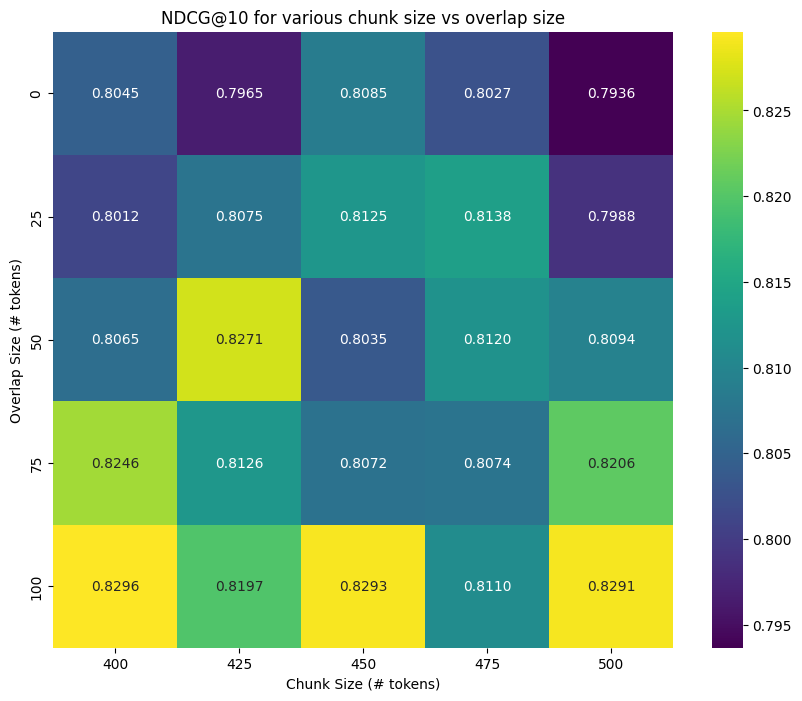

In [16]:
heatmap_of_metric_at_k(list_configs,
                        results["the_df_dataset"],
                        metric="ndcg", 
                        k=50, 
                        title="NDCG@10 for various chunk size vs overlap size", 
                        cmap_name='viridis')

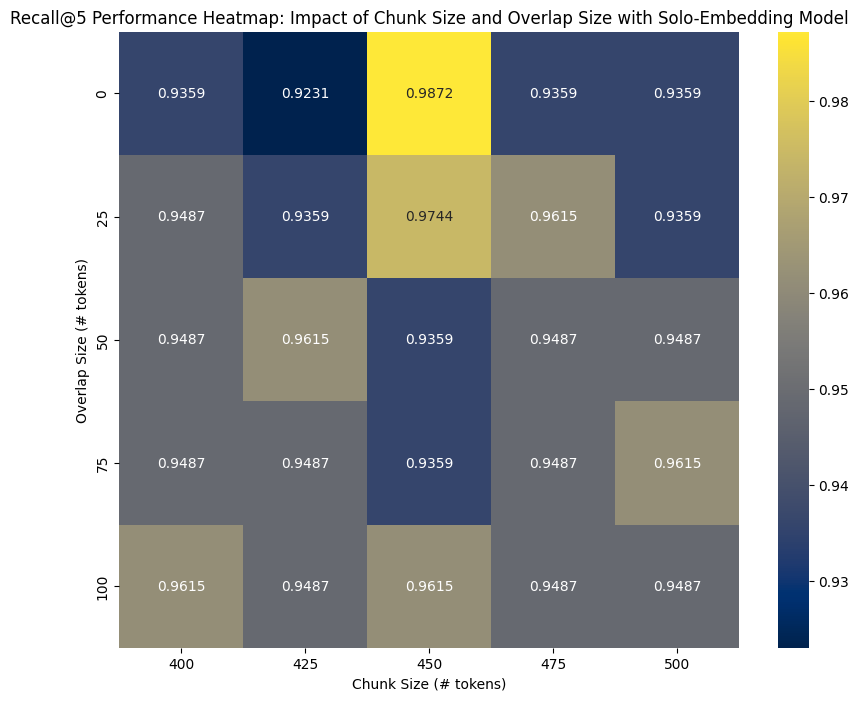

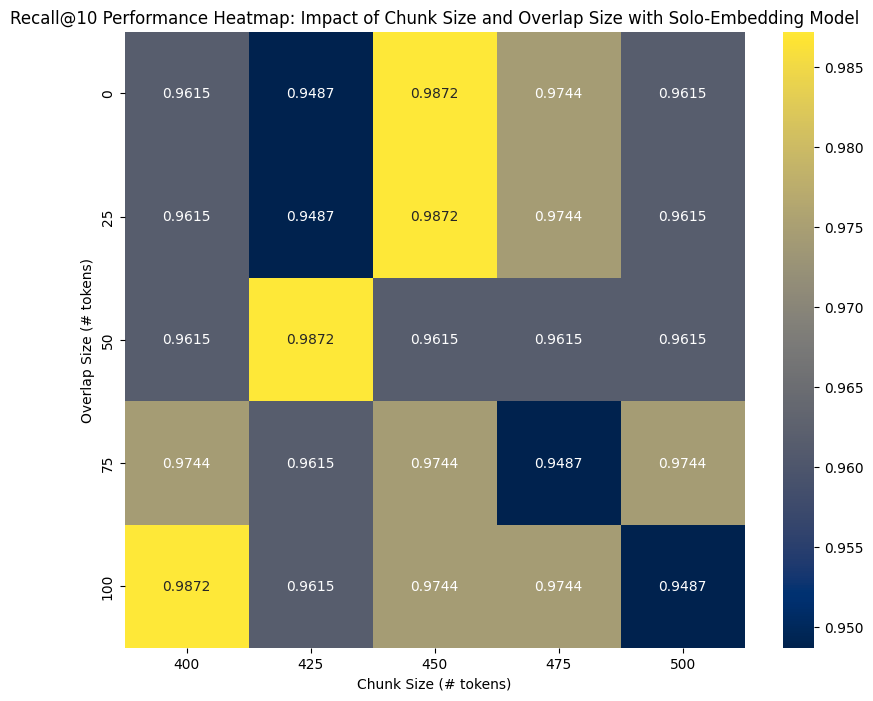

In [34]:
heatmap_of_metric_at_k(list_configs,
                        results["the_df_dataset"],
                        metric="recall", 
                        k=5, 
                        title="Recall@5 Performance Heatmap: Impact of Chunk Size and Overlap Size with Solo-Embedding Model", 
                        cmap_name='cividis')

heatmap_of_metric_at_k(list_configs,
                        results["the_df_dataset"],
                        metric="recall", 
                        k=10, 
                        title="Recall@10 Performance Heatmap: Impact of Chunk Size and Overlap Size with Solo-Embedding Model", 
                        cmap_name='cividis')                       

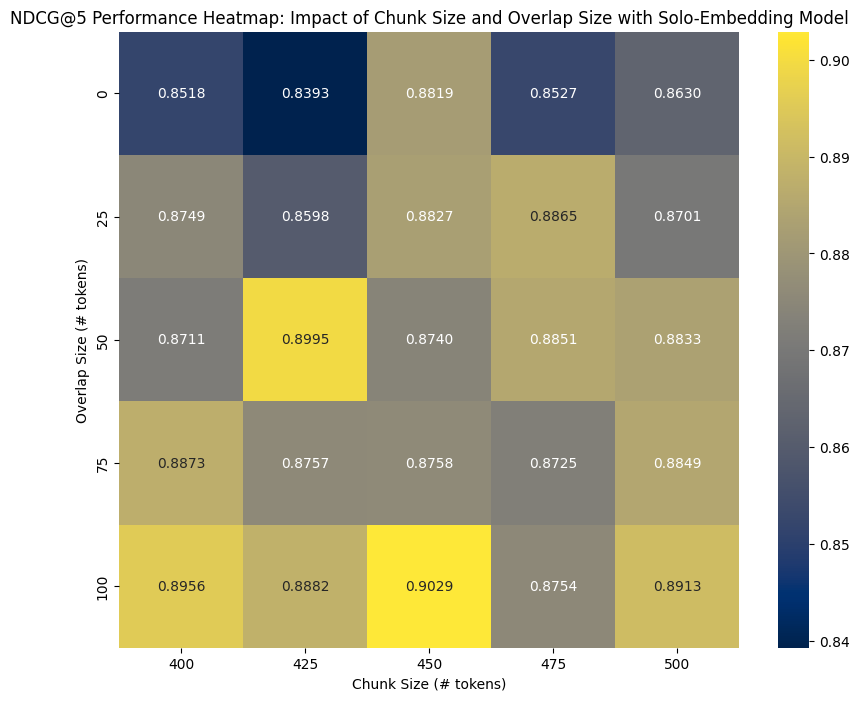

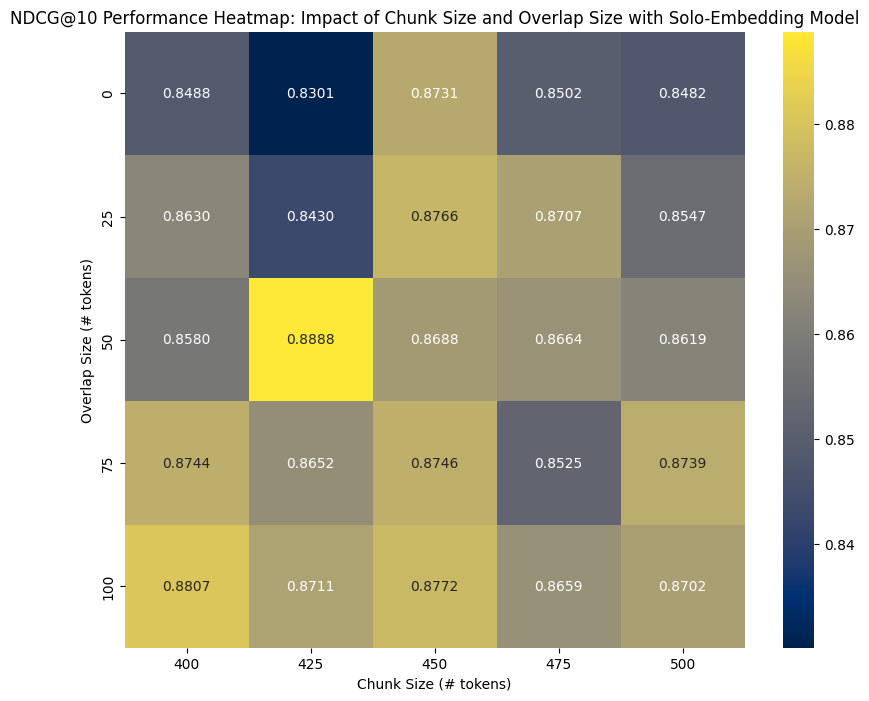

In [32]:
heatmap_of_metric_at_k(list_configs,
                        results["the_df_dataset"],
                        metric="ndcg", 
                        k=5, 
                        title="NDCG@5 Performance Heatmap: Impact of Chunk Size and Overlap Size with Solo-Embedding Model", 
                        cmap_name='cividis')

heatmap_of_metric_at_k(list_configs,
                        results["the_df_dataset"],
                        metric="ndcg", 
                        k=10, 
                        title="NDCG@10 Performance Heatmap: Impact of Chunk Size and Overlap Size with Solo-Embedding Model", 
                        cmap_name='cividis')     

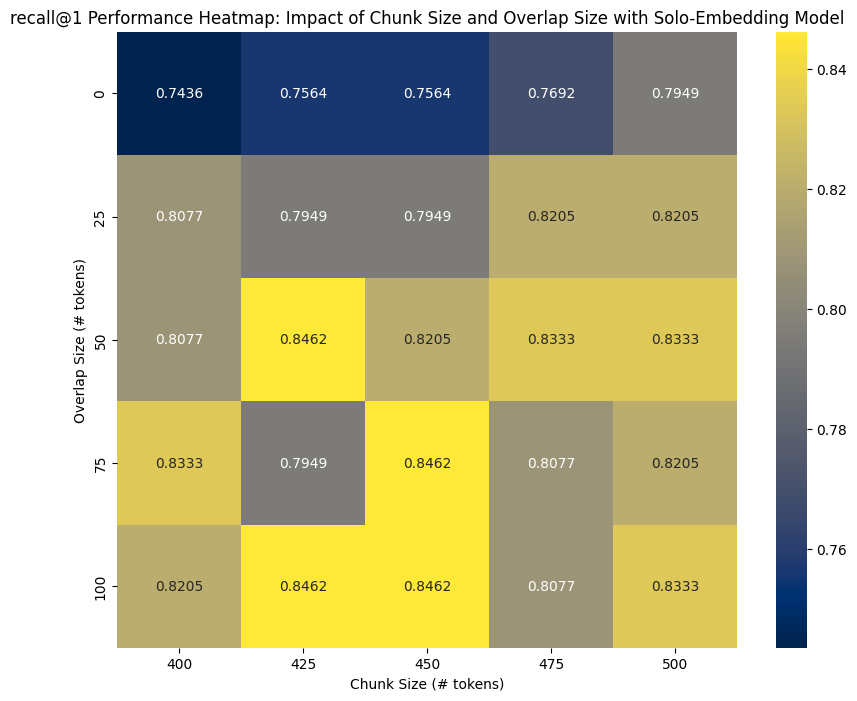

In [39]:
heatmap_of_metric_at_k(list_configs,
                        results["the_df_dataset"],
                        metric="recall", 
                        k=1, 
                        title="recall@1 Performance Heatmap: Impact of Chunk Size and Overlap Size with Solo-Embedding Model", 
                        cmap_name='cividis')  